# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [3]:
from sklearn.datasets import make_circles, make_moons, load_breast_cancer, make_regression

# Code

In [4]:
class Sampler:
    
    def __init__(self):
        pass
        
    def sample(self, sample_size: int, bag_size: int):
        # выборка без возвращений
        indixes = np.random.choice(np.arange(sample_size), bag_size, replace=False)
        return indixes

In [5]:
class Bagger:
    
    def __init__(self, estimator: str, n_estimators: int = 10, max_features: int = None, max_sample_size: int = None):
        
        if estimator not in ('tree', 'knn'):
            raise NotImplementedError
        
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_sample_size = max_sample_size
        self.sampler = Sampler()
        self.estimators = []
        self.estimator = estimator
        
    def fit(self, X, y):
        if (self.max_features is None) or (self.max_features > X.shape[1]):
            self.max_features = X.shape[1]
        if (self.max_sample_size is None) or (self.max_sample_size > X.shape[0]):
            self.max_sample_size = X.shape[0]
            
        for i in range(self.n_estimators):
            n_indixes = self.sampler.sample(X.shape[0], self.max_sample_size)
            m_indixes = np.sort(self.sampler.sample(X.shape[1], self.max_features))
            x_batch = X[n_indixes][:, m_indixes]
            y_batch = y[n_indixes]
            
            estimator = self.estimator.fit(x_batch, y_batch)

#             plt.figure()
#             eps = 0.4
#             xx, yy = np.meshgrid(np.linspace(np.min(x_batch[:,0]) - eps, np.max(x_batch[:,0]) + eps, 100),
#                              np.linspace(np.min(x_batch[:,1]) - eps, np.max(x_batch[:,1]) + eps, 100))
            
#             z = estimator.predict(np.c_[xx.ravel(), yy.ravel()][:, :]).reshape(xx.shape)
            
#             plt.pcolormesh(xx, yy, z, cmap='Spectral', shading='auto')
#             plt.scatter(x_batch[:, 0], x_batch[:, 1], c=y_batch)
            
            
            self.estimators.append((estimator, m_indixes))
        return self

In [6]:
class BaggerRegressor(Bagger):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        if self.estimator == 'tree':
            self.estimator = DecisionTreeRegressor(random_state=42)
        elif self.estimator == 'knn':
            self.estimator = KNeighborsRegressor(n_neighbors=1)
    
    def predict(self, X):
        preds = []
        for estimator, m_indixes in self.estimators:
            y_pred = estimator.predict(X[:, m_indixes])
            preds.append(y_pred)
        return np.mean(preds, axis=0)

In [7]:
class BaggerClassifier(Bagger):
    
    def __init__(self, voiting='soft', **kwargs):
        super().__init__(**kwargs)
        
        if voiting not in ('hard', 'soft'):
            raise NotImplementedError
            
        self.voiting = voiting
        print(self.estimator)
        if self.estimator == 'tree':
            self.estimator = DecisionTreeClassifier(random_state=42)
        elif self.estimator == 'knn':
            self.estimator = KNeighborsClassifier(n_neighbors=1)
    
    def predict_proba(self, X):
        preds = []
        for estimator, m_indixes in self.estimators:
            y_pred = estimator.predict_proba(X[:, m_indixes])
            preds.append(y_pred)
        return np.mean(preds, axis=0)
    
    def predict(self, X):
        if self.voiting == 'hard':
            preds = np.empty(shape=(0, X.shape[0]))
            
            for estimator, m_indixes in self.estimators:
                y_pred = estimator.predict(X[:, m_indixes]).reshape(1, -1)
                preds = np.concatenate([preds, y_pred], axis=0)
            print(preds)
            values, counts = np.unique(preds, axis=0, return_counts=True)
            return values[np.argmax(counts)]
        
        elif self.voiting == 'soft':
            preds = self.predict_proba(X)
            return np.argmax(preds, axis=1)

## Helpers

In [8]:
def plot_mesh_grid(clf_list, X, y):
    i = 1
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    for clf in clf_list:
        plt.subplot(1, 2, i)
    
        eps = 0.3

        xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 100),
                             np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 100))
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()][:, :]).reshape(xx.shape)

        plt.pcolormesh(xx, yy, z, cmap='Spectral', shading='auto')
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral', edgecolors='black')
        plt.title(clf.estimator)
        
        i+=1

In [9]:
def fit_ensemble(X, y, task):
    
    if task == 'clf':
    
        bag_knn = BaggerClassifier(estimator='knn', 
                       n_estimators=100, 
                       max_features=2, 
                       max_sample_size=100, 
                       voiting='soft')

        bag_tree = BaggerClassifier(estimator='tree', 
                       n_estimators=100, 
                       max_sample_size=100, 
                       voiting='soft')
        
    else:
        
        bag_knn = BaggerRegressor(
                         estimator='knn',
                         n_estimators=20,
                         max_sample_size=50,
                        )
        
        bag_tree = BaggerRegressor(
                         estimator='tree',
                         n_estimators=20,
                         max_sample_size=50,
                        )
    
    bag_knn.fit(X, y)
    bag_tree.fit(X, y)
    
    return bag_knn, bag_tree

## Classification

### Moons

In [10]:
X, y = make_moons(300, noise=0.2, random_state=42)

In [11]:
clf_knn, clf_tree = fit_ensemble(X, y, 'clf')

knn
tree


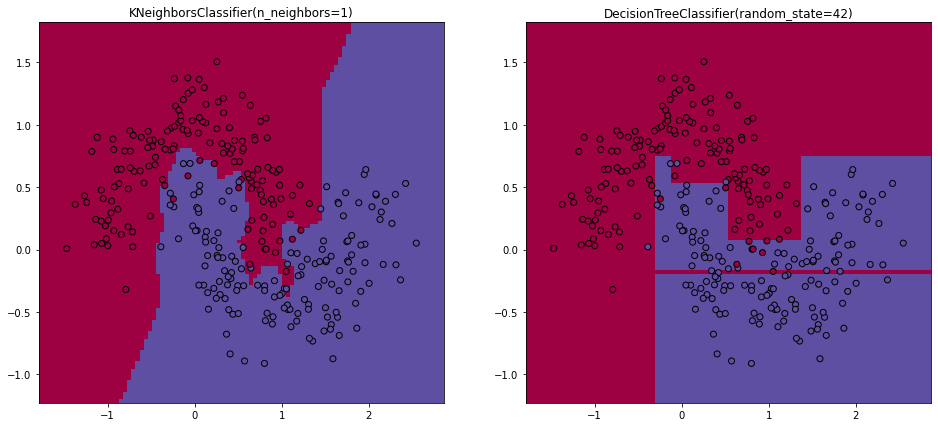

In [12]:
plot_mesh_grid([clf_knn, clf_tree], X, y)

### Circles

In [13]:
X, y = make_circles(300, noise=0.2, random_state=42, factor=0.2)

In [14]:
clf_knn, clf_tree = fit_ensemble(X, y, 'clf')

knn
tree


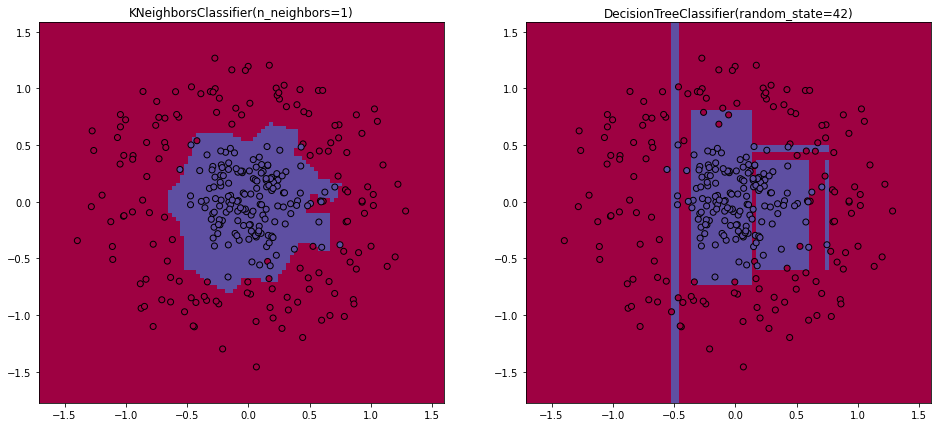

In [15]:
plot_mesh_grid([clf_knn, clf_tree], X, y)

## Regression

In [16]:
X, y = make_regression(n_samples=100, n_features=1, random_state=42, noise = 5)

In [17]:
reg_knn, reg_tree = fit_ensemble(X, y, 'reg')

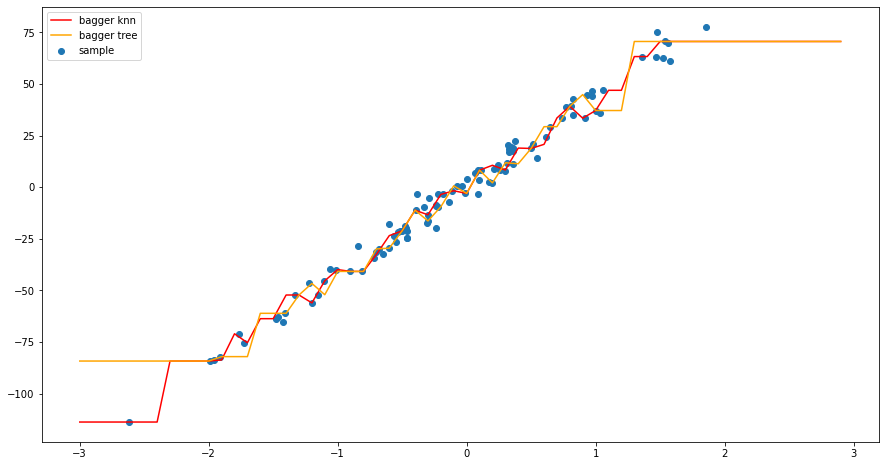

In [18]:
plt.figure(figsize=(15,8))
t = np.arange(-3, 3, 0.1).reshape(60,1)
pred_knn = reg_knn.predict(t)
pred_tree = reg_tree.predict(t)
plt.plot(t, pred_knn, color='red', label='bagger knn')
plt.plot(t, pred_tree, color='orange', label='bagger tree')
plt.scatter(X, y, label='sample')
plt.legend()